# [Genre] Experiment 1 - Differents Type of Inputs
For the first experiment, I evaluate mel spectrograms, spectrograms, and MFCC representations as input of a 3-layer CNN inspired and adapted from Choi et al. [[1]](#one) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
import os
import json
import pickle
import csv
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Activation, BatchNormalization, ReLU, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
DRIVE_PATH = '/content/drive/My Drive/'
sys.path.append(DRIVE_PATH)

import utility
from utility import DataGenerator

SPLITS_DIR = DRIVE_PATH + 'genre-splits/experiment-1/'
MELSPECS_DIR = DRIVE_PATH + 'genre-melspecs-10000/'
SPECS_DIR = DRIVE_PATH + 'genre-specs-10000/'
MFCCS_DIR = DRIVE_PATH + 'genre-mfccs-10000/'
MODELS_DIR = DRIVE_PATH + 'genre-models/experiment-1/'
RESULTS_DIR = DRIVE_PATH + 'genre-results/'
PICKLES_DIR = DRIVE_PATH + 'genre-pickles/'

NUM_CLASSES = 10
NUM_EPOCHS = 20
BATCH_SIZE = 128

# 1. Loading the data

In [ ]:
# Loading the label map
with open(DRIVE_PATH + 'genre_label_map.json', 'r') as output:
    label_map = json.load(output)

label_map

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [ ]:
# Mel spectrograms
X_train_filenames_melspec = np.load(SPLITS_DIR + 'X_train_filenames_melspec.npy')
X_val_filenames_melspec = np.load(SPLITS_DIR + 'X_val_filenames_melspec.npy')
X_test_filenames_melspec = np.load(SPLITS_DIR + 'X_test_filenames_melspec.npy')

one_hot_y_train_melspec = np.load(SPLITS_DIR + 'one_hot_y_train_melspec.npy')
one_hot_y_val_melspec = np.load(SPLITS_DIR + 'one_hot_y_val_melspec.npy')
one_hot_y_test_melspec = np.load(SPLITS_DIR + 'one_hot_y_test_melspec.npy')

# Spectrograms
X_train_filenames_spec = np.load(SPLITS_DIR + 'X_train_filenames_spec.npy')
X_val_filenames_spec = np.load(SPLITS_DIR + 'X_val_filenames_spec.npy')
X_test_filenames_spec = np.load(SPLITS_DIR + 'X_test_filenames_spec.npy')

one_hot_y_train_spec = np.load(SPLITS_DIR + 'one_hot_y_train_spec.npy')
one_hot_y_val_spec = np.load(SPLITS_DIR + 'one_hot_y_val_spec.npy')
one_hot_y_test_spec = np.load(SPLITS_DIR + 'one_hot_y_test_spec.npy')

# MFCCs
X_train_filenames_mfcc = np.load(SPLITS_DIR + 'X_train_filenames_mfcc.npy')
X_val_filenames_mfcc = np.load(SPLITS_DIR + 'X_val_filenames_mfcc.npy')
X_test_filenames_mfcc = np.load(SPLITS_DIR + 'X_test_filenames_mfcc.npy')

one_hot_y_train_mfcc = np.load(SPLITS_DIR + 'one_hot_y_train_mfcc.npy')
one_hot_y_val_mfcc = np.load(SPLITS_DIR + 'one_hot_y_val_mfcc.npy')
one_hot_y_test_mfcc = np.load(SPLITS_DIR + 'one_hot_y_test_mfcc.npy')

In [ ]:
print('Mel spectrograms')
print("Train set:", X_train_filenames_melspec.shape, one_hot_y_train_melspec.shape)
print("Validation set:", X_val_filenames_melspec.shape, one_hot_y_val_melspec.shape)
print("Test set:", X_test_filenames_melspec.shape, one_hot_y_test_melspec.shape)

print('\nSpectrograms')
print("Train set:", X_train_filenames_spec.shape, one_hot_y_train_spec.shape)
print("Validation set:", X_val_filenames_spec.shape, one_hot_y_val_spec.shape)
print("Test set:", X_test_filenames_spec.shape, one_hot_y_test_spec.shape)

print('\nMFCCs')
print("Train set:", X_train_filenames_mfcc.shape, one_hot_y_train_mfcc.shape)
print("Validation set:", X_val_filenames_mfcc.shape, one_hot_y_val_mfcc.shape)
print("Test set:", X_test_filenames_mfcc.shape, one_hot_y_test_mfcc.shape)

Mel spectrograms
Train set: (8000,) (8000, 10)
Validation set: (1000,) (1000, 10)
Test set: (1000,) (1000, 10)

Spectrograms
Train set: (8000,) (8000, 10)
Validation set: (1000,) (1000, 10)
Test set: (1000,) (1000, 10)

MFCCs
Train set: (8000,) (8000, 10)
Validation set: (1000,) (1000, 10)
Test set: (1000,) (1000, 10)


# 2. Creating generators


In [ ]:
# Replacing filenames by the absolute path to filenames
X_train_filenames_melspec = np.array([MELSPECS_DIR + fn for fn in X_train_filenames_melspec])
X_val_filenames_melspec = np.array([MELSPECS_DIR + fn for fn in X_val_filenames_melspec])
X_test_filenames_melspec = np.array([MELSPECS_DIR + fn for fn in X_test_filenames_melspec])

X_train_filenames_spec = np.array([SPECS_DIR + fn for fn in X_train_filenames_spec])
X_val_filenames_spec = np.array([SPECS_DIR + fn for fn in X_val_filenames_spec])
X_test_filenames_spec = np.array([SPECS_DIR + fn for fn in X_test_filenames_spec])

X_train_filenames_mfcc = np.array([MFCCS_DIR + fn for fn in X_train_filenames_mfcc])
X_val_filenames_mfcc = np.array([MFCCS_DIR + fn for fn in X_val_filenames_mfcc])
X_test_filenames_mfcc = np.array([MFCCS_DIR + fn for fn in X_test_filenames_mfcc])

In [ ]:
# Determining the shape of each type of input
def compute_shape(filename):
  x = np.load(filename)
  shape = x.shape
  return shape

melspec_shape = compute_shape(X_train_filenames_melspec[0])
spec_shape = compute_shape(X_train_filenames_spec[0])
mfcc_shape = compute_shape(X_train_filenames_mfcc[0])

print(f'Mel spectrogram shape: {melspec_shape}')
print(f'Spectrogram shape: {spec_shape}')
print(f'MFCC shape: {mfcc_shape}')

Mel spectrogram shape: (128, 130)
Spectrogram shape: (513, 130)
MFCC shape: (20, 130)


In [ ]:
# Mel spectrograms
train_generator_melspec = DataGenerator(X_train_filenames_melspec, one_hot_y_train_melspec, BATCH_SIZE, melspec_shape, 1)
validation_generator_melspec = DataGenerator(X_val_filenames_melspec, one_hot_y_val_melspec, BATCH_SIZE, melspec_shape, 1)
test_generator_melspec = DataGenerator(X_test_filenames_melspec, one_hot_y_test_melspec, BATCH_SIZE, melspec_shape, 1)

# Spectrograms
train_generator_spec = DataGenerator(X_train_filenames_spec, one_hot_y_train_spec, BATCH_SIZE, spec_shape, 1)
validation_generator_spec = DataGenerator(X_val_filenames_spec, one_hot_y_val_spec, BATCH_SIZE, spec_shape, 1)
test_generator_spec = DataGenerator(X_test_filenames_spec, one_hot_y_test_spec, BATCH_SIZE, spec_shape, 1)

# MFCCs
train_generator_mfcc = DataGenerator(X_train_filenames_mfcc, one_hot_y_train_mfcc, BATCH_SIZE, mfcc_shape)
validation_generator_mfcc = DataGenerator(X_val_filenames_mfcc, one_hot_y_val_mfcc, BATCH_SIZE, mfcc_shape)
test_generator_mfcc = DataGenerator(X_test_filenames_mfcc, one_hot_y_test_mfcc, BATCH_SIZE, mfcc_shape)

# 3. Building and training the models
The architecture is inspired and adapted from Choi et al. [[1]](#one) 

I changed the overall architecture because the inputs' size were different from Choi et al. but decided to keep the poolings size and the time-axis pooling (instead of 2D convolutions and poolings) for MFCCs because relevant information is represented by each MFCC rather than its local relationships as stated in the article. 

In [ ]:
def build_cnn_2d(input_shape, nb_filters, dense_units, output_shape=NUM_CLASSES, activation='softmax', dropout=0.3, poolings=None):
    
    n_mels = input_shape[0]
    
    if not poolings:
      if n_mels >= 256:
          poolings = [(2, 4), (4, 4), (4, 5), (2, 4), (4, 4)]
      elif n_mels >= 128:
          poolings = [(2, 4), (4, 4), (2, 5), (2, 4), (4, 4)]
      elif n_mels >= 96:
          poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (4, 4)]
      elif n_mels >= 72:
          poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (3, 4)]
      elif n_mels >= 64:
          poolings = [(2, 4), (2, 4), (2, 5), (2, 4), (4, 4)]
    
    # Input block
    melspec_input = Input(shape=input_shape, name='input')

    # Conv block 1
    x = Conv2D(nb_filters[0], (3, 3), activation='relu', name='conv_1')(melspec_input)
    x = MaxPooling2D(pool_size=poolings[0], strides=2, padding='same', name='pool_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    
    # Conv block 2
    x = Conv2D(nb_filters[1], (3, 3), activation='relu', name='conv_2')(x)
    x = MaxPooling2D(pool_size=poolings[1], strides=2, padding='same', name='pool_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    
    # Conv block 3
    x = Conv2D(nb_filters[2], (3, 3), activation='relu', name='conv_3')(x)
    x = MaxPooling2D(pool_size=poolings[2], strides=2, padding='same', name='pool_3')(x)
    x = BatchNormalization(name='bn_3')(x)
    
    # Flattening the output and feeding it into dense layer
    x = Flatten(name='flatten')(x)
    x = Dense(dense_units, activation='relu', name='dense')(x)
    x = Dropout(dropout, name='dropout')(x)
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'dense_output')(x)
    
    # Create model
    model = Model(melspec_input, x)
    
    return model

In [ ]:
def create_checkpoint(filepath):
  checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_accuracy', 
                              verbose=0, 
                              save_best_only=False)
  return checkpoint

In [ ]:
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=1, 
                                         verbose=0)

## 3.1. CNN for Mel spectrograms

In [ ]:
cnn_melspec = build_cnn_2d((melspec_shape[0],melspec_shape[1], 1), [32,32,32], 64)
cnn_melspec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 130, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 126, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 63, 64, 32)        0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 63, 64, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 62, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 32)        0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 31, 31, 32)        128   

In [ ]:
# Compiling our neural network
cnn_melspec.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])

In [ ]:
# Creating callbacks list
filepath = MODELS_DIR + 'melspec/cnn_3_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'

callbacks_list = [create_checkpoint(filepath), reduce_lr_on_plateau]

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(X_train_filenames_melspec)/BATCH_SIZE)
VAL_STEPS = np.ceil(len(X_val_filenames_melspec)/BATCH_SIZE)

cnn_melspec_hist = cnn_melspec.fit(x=train_generator_melspec,
                                  epochs=NUM_EPOCHS,
                                  steps_per_epoch=STEPS_PER_EPOCH,
                                  validation_data=validation_generator_melspec,
                                  validation_steps=VAL_STEPS,
                                  callbacks=callbacks_list)

Epoch 1/20
63/63 [==============================] - 2038s 32s/step - loss: 1.6698 - accuracy: 0.4257 - val_loss: 4.8730 - val_accuracy: 0.1150 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 170s 3s/step - loss: 1.1020 - accuracy: 0.6227 - val_loss: 1.7347 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 171s 3s/step - loss: 0.8486 - accuracy: 0.7088 - val_loss: 1.5076 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 170s 3s/step - loss: 0.6436 - accuracy: 0.7785 - val_loss: 1.0086 - val_accuracy: 0.6540 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - 172s 3s/step - loss: 0.5204 - accuracy: 0.8186 - val_loss: 0.9532 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 6/20
63/63 [==============================] - 170s 3s/step - loss: 0.4388 - accuracy: 0.8430 - val_loss: 0.9213 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 7/20
63/63 [==============================] - 170s 3s/step - loss: 0

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_1_cnn_3_mel_history.pkl', 'wb') as f:
    pickle.dump(cnn_melspec_hist.history, f)

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_1_cnn_3_mel_history.pkl', 'rb') as f:
    cnn_melspec_hist_dict = pickle.load(f)

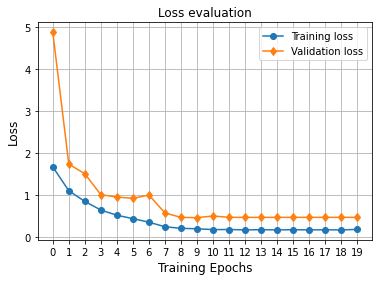

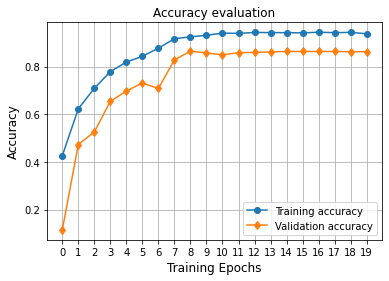

In [ ]:
utility.plot_history(cnn_melspec_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + 'melspec/cnn_3_melspec')

In [ ]:
# Loading the best performing model
cnn_melspec = load_model(filepath=MODELS_DIR + 'melspec/cnn_3_mel_epoch_16_acc_0.9410_val_acc_0.8630.h5')

## 3.2. CNN for Spectrograms

In [ ]:
cnn_spec = build_cnn_2d((spec_shape[0], spec_shape[1], 1), [32,32,32], 64)
cnn_spec.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 513, 130, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 511, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 256, 64, 32)       0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 256, 64, 32)       128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 62, 32)       9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 127, 31, 32)       0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 127, 31, 32)       128 

In [ ]:
# Compiling our neural network
cnn_spec.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])

In [ ]:
# Creating callbacks list
filepath = MODELS_DIR + 'spec/cnn_3_spec_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'

callbacks_list = [create_checkpoint(filepath), reduce_lr_on_plateau]

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(X_train_filenames_spec)/BATCH_SIZE)
VAL_STEPS = np.ceil(len(X_val_filenames_spec)/BATCH_SIZE)

# 3H15
cnn_spec_hist = cnn_spec.fit(x=train_generator_spec,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_data=validation_generator_spec,
                              validation_steps=VAL_STEPS,
                              callbacks=callbacks_list)

Epoch 1/20
63/63 [==============================] - 2327s 37s/step - loss: 2.2760 - accuracy: 0.2641 - val_loss: 119.4637 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 667s 11s/step - loss: 1.7709 - accuracy: 0.3849 - val_loss: 12.7990 - val_accuracy: 0.1450 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 668s 11s/step - loss: 1.5737 - accuracy: 0.4548 - val_loss: 1.8287 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 666s 11s/step - loss: 1.4353 - accuracy: 0.4975 - val_loss: 2.0929 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - 662s 11s/step - loss: 1.2611 - accuracy: 0.5439 - val_loss: 1.4613 - val_accuracy: 0.5570 - lr: 1.0000e-04
Epoch 6/20
63/63 [==============================] - 661s 10s/step - loss: 1.1911 - accuracy: 0.5634 - val_loss: 1.4206 - val_accuracy: 0.5720 - lr: 1.0000e-04
Epoch 7/20
63/63 [==============================] - 663s 1

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_1_cnn_3_spec_history.pkl', 'wb') as f:
    pickle.dump(cnn_spec_hist.history, f)

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_1_cnn_3_spec_history.pkl', 'rb') as f:
    cnn_spec_hist_dict = pickle.load(f)

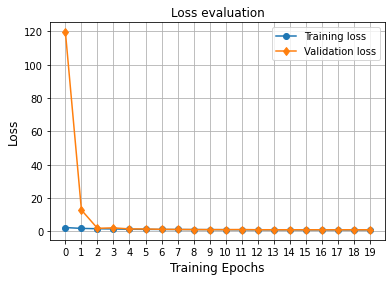

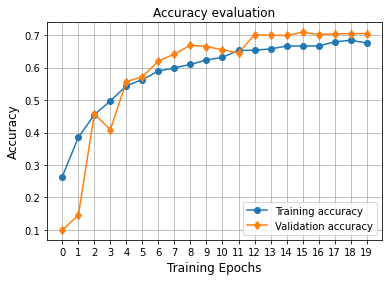

In [ ]:
utility.plot_history(cnn_spec_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + 'spec/cnn_3_spec')

In [ ]:
# Loading the best performing model
cnn_spec = load_model(filepath=MODELS_DIR+'spec/cnn_3_spec_epoch_18_acc_0.6794_val_acc_0.7040.h5')

## 3.3. CNN for MFCC

In [ ]:
def build_cnn_1d(input_shape, nb_filters, dense_units, output_shape=NUM_CLASSES, activation='softmax', dropout=0.3, poolings=None):
    
  model = Sequential()

  # Conv block 1
  model.add(Conv1D(nb_filters[0], 3, activation='relu', input_shape=input_shape, name='conv_1'))
  model.add(MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool_1'))
  model.add(BatchNormalization(name='bn_1'))
  
  # Conv block 2
  model.add(Conv1D(nb_filters[1], 3, activation='relu', name='conv_2'))
  model.add(MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool_2'))
  model.add(BatchNormalization(name='bn_2'))
  
  # Conv block 3
  model.add(Conv1D(nb_filters[2], 3, activation='relu', name='conv_3'))
  model.add(MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool_3'))
  model.add(BatchNormalization(name='bn_3'))
  
  # Flattening the output and feeding it into dense layer
  model.add(Flatten(name='flatten'))
  model.add(Dense(dense_units, activation='relu', name='dense'))
  model.add(Dropout(dropout, name='dropout'))
  
  # Output Layer
  model.add(Dense(output_shape, activation=activation, name = 'dense_output'))
  
  return model

In [ ]:
cnn_mfcc = build_cnn_1d(mfcc_shape, [32,32,32], 64)
cnn_mfcc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 18, 32)            12512     
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 9, 32)             0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 9, 32)             128       
_________________________________________________________________
conv_2 (Conv1D)              (None, 7, 32)             3104      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 4, 32)             0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 4, 32)             128       
_________________________________________________________________
conv_3 (Conv1D)              (None, 2, 32)             3

In [ ]:
# Compiling our neural network
cnn_mfcc.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])

In [ ]:
# Creating callbacks list
filepath = MODELS_DIR + 'mfcc/cnn_3_mfcc_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'

callbacks_list = [create_checkpoint(filepath), reduce_lr_on_plateau]

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(X_train_filenames_mfcc)/BATCH_SIZE)
VAL_STEPS = np.ceil(len(X_val_filenames_mfcc)/BATCH_SIZE)

cnn_mfcc_hist = cnn_mfcc.fit(x=train_generator_mfcc,
                            epochs=NUM_EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_data=validation_generator_mfcc,
                            validation_steps=VAL_STEPS,
                            callbacks=callbacks_list)

Epoch 1/20
63/63 [==============================] - 2328s 37s/step - loss: 2.1475 - accuracy: 0.2249 - val_loss: 2.3753 - val_accuracy: 0.1690 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 19s 297ms/step - loss: 1.7089 - accuracy: 0.3801 - val_loss: 2.1338 - val_accuracy: 0.2470 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 18s 293ms/step - loss: 1.5115 - accuracy: 0.4481 - val_loss: 1.9516 - val_accuracy: 0.3070 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 19s 295ms/step - loss: 1.3906 - accuracy: 0.4919 - val_loss: 1.5767 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - 20s 319ms/step - loss: 1.2953 - accuracy: 0.5294 - val_loss: 1.3864 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 6/20
63/63 [==============================] - 19s 300ms/step - loss: 1.2232 - accuracy: 0.5640 - val_loss: 1.2623 - val_accuracy: 0.5290 - lr: 0.0010
Epoch 7/20
63/63 [==============================] - 19s 295ms/st

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_1_cnn_3_mfcc_history.pkl', 'wb') as f:
    pickle.dump(cnn_mfcc_hist.history, f)

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_1_cnn_3_mfcc_history.pkl', 'rb') as f:
    cnn_mfcc_hist_dict = pickle.load(f)

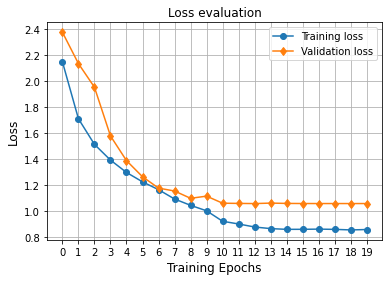

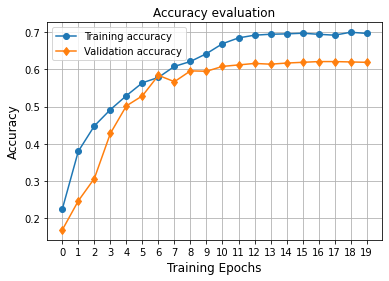

In [ ]:
utility.plot_history(cnn_mfcc_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + 'mfcc/cnn_3_mfcc')

In [ ]:
# Loading the best performing model
cnn_mfcc = load_model(filepath=MODELS_DIR+'mfcc/cnn_3_mfcc_epoch_18_acc_0.6919_val_acc_0.6210.h5')

# 4. Save scores

In [ ]:
def compute_scores(y_true, y_pred, one_hot_y_true, pred_proba):
  accuracy = accuracy_score(y_pred, y_true)
  precision_macro = precision_score(y_pred, y_true, average='macro')
  recall_macro = recall_score(y_pred, y_true, average='macro', labels=np.unique(y_pred))
  f1_score_macro = f1_score(y_pred, y_true, average='macro')
  roc_auc_macro = roc_auc_score(one_hot_y_true, pred_proba, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision macro: {precision_macro}')
  print(f'Recall macro: {recall_macro}')
  print(f'F1 score macro: {f1_score_macro}')
  print(f'ROC AUC macro: {roc_auc_macro}')

  return accuracy, precision_macro, recall_macro, f1_score_macro, roc_auc_macro

In [ ]:
def save_scores(model_name, scores):
  row = [model_name]
  row.extend(scores)
  
  with open(RESULTS_DIR + 'genre_all_models_scores.csv', 'a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)
  

In [ ]:
def plot_confusion_matrix(cm, title, save_path=None, classes=label_map.keys()):
  plt.figure(figsize=(13,6))
  sns.heatmap(cm,
              annot=True,
              fmt='d',
              xticklabels=classes,
              yticklabels=classes,
              cmap='Blues')
              
  plt.ylabel('Predicted labels')
  plt.xlabel('Actual labels')
  plt.title(title)
  if save_path:
    plt.savefig(save_path)
  plt.show()
  plt.close()

## 4.1. Mel spectrograms

In [ ]:
# Making predictions on test set
TEST_STEPS_MELSPEC = np.ceil(len(X_test_filenames_melspec)/BATCH_SIZE)
pred_proba_melspec = cnn_melspec.predict(x=test_generator_melspec, steps=TEST_STEPS_MELSPEC)

In [ ]:
y_pred_melspec = np.argmax(pred_proba_melspec, axis=1)
y_test_melspec = np.argmax(one_hot_y_test_melspec, axis=1)

In [ ]:
scores_melspec = compute_scores(y_test_melspec, y_pred_melspec, one_hot_y_test_melspec, pred_proba_melspec)

Accuracy: 0.866
Precision macro: 0.866
Recall macro: 0.8676595905140838
F1 score macro: 0.8658044583919114
ROC AUC macro: 0.9879744444444445


In [ ]:
save_scores('exp_1_cnn_3_mel', scores_melspec)

__Confusion Matrix__

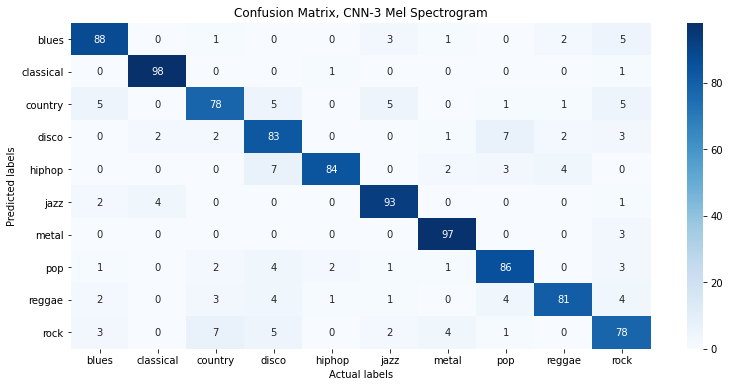

In [ ]:
cm_melspec = confusion_matrix(y_test_melspec, y_pred_melspec)
plot_confusion_matrix(cm=cm_melspec, title='Confusion Matrix, CNN-3 Mel Spectrogram', save_path=RESULTS_DIR+'cm_exp_1_cnn_3_mel.png')

## 4.2. Spectrograms

In [ ]:
# Making predictions on test set
TEST_STEPS_SPEC = np.ceil(len(X_test_filenames_spec)/BATCH_SIZE)
pred_proba_spec = cnn_spec.predict(x=test_generator_spec, steps=TEST_STEPS_SPEC)

In [ ]:
y_pred_spec = np.argmax(pred_proba_spec, axis=1)
y_test_spec = np.argmax(one_hot_y_test_spec, axis=1)

In [ ]:
scores_spec = compute_scores(y_test_spec, y_pred_spec, one_hot_y_test_spec, pred_proba_spec)

Accuracy: 0.7
Precision macro: 0.7
Recall macro: 0.6935063976898401
F1 score macro: 0.6861370168372328
ROC AUC macro: 0.9512188888888888


In [ ]:
save_scores('exp_1_cnn_3_spec', scores_spec)

__Confusion Matrix__

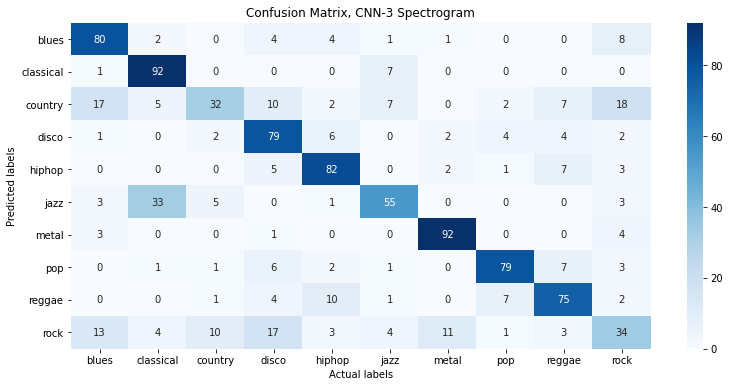

In [ ]:
cm_spec = confusion_matrix(y_test_spec, y_pred_spec)
plot_confusion_matrix(cm=cm_spec, title='Confusion Matrix, CNN-3 Spectrogram', save_path=RESULTS_DIR+'cm_exp_1_cnn_3_spec.png')

## 4.3. MFCCs

In [ ]:
# Making predictions on test set
TEST_STEPS_MFCC = np.ceil(len(X_test_filenames_mfcc)/BATCH_SIZE)
pred_proba_mfcc = cnn_mfcc.predict(x=test_generator_mfcc, steps=TEST_STEPS_MFCC)

In [ ]:
y_pred_mfcc = np.argmax(pred_proba_mfcc, axis=1)
y_test_mfcc = np.argmax(one_hot_y_test_mfcc, axis=1)

In [ ]:
scores_mfcc = compute_scores(y_test_mfcc, y_pred_mfcc, one_hot_y_test_mfcc, pred_proba_mfcc)

Accuracy: 0.611
Precision macro: 0.611
Recall macro: 0.6102728697862484
F1 score macro: 0.6086856894166608
ROC AUC macro: 0.9203533333333332


In [ ]:
save_scores('exp_1_cnn_3_mfcc', scores_mfcc)

__Confusion Matrix__


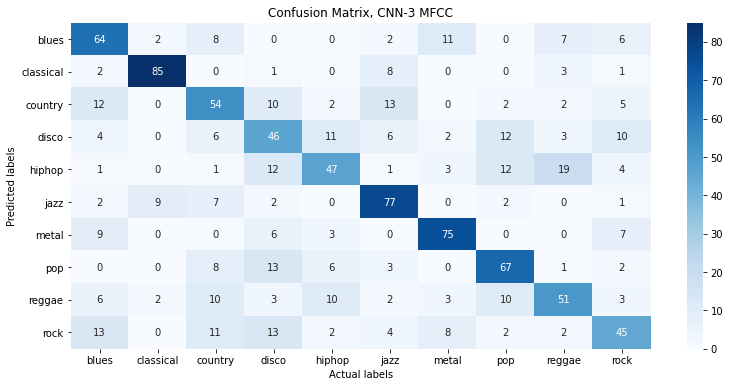

In [ ]:
cm_mfcc = confusion_matrix(y_test_mfcc, y_pred_mfcc)
plot_confusion_matrix(cm=cm_mfcc, title='Confusion Matrix, CNN-3 MFCC', save_path=RESULTS_DIR+'cm_exp_1_cnn_3_mfcc.png')

## 4.4. ROC AUC Comparison

In [ ]:
def compute_roc_curve(y_test, y_score):

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(NUM_CLASSES):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(NUM_CLASSES):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= NUM_CLASSES

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  return fpr, tpr, roc_auc

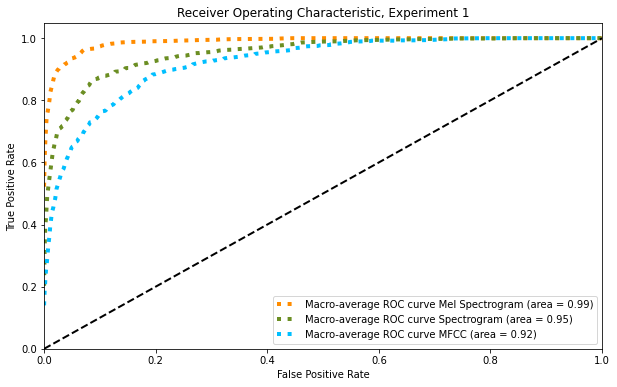

In [ ]:
# Plot linewidth.
lw = 2

# Compute macro-average ROC curve and ROC area
fpr_melspec, tpr_melspec, roc_auc_melspec = compute_roc_curve(one_hot_y_test_melspec, pred_proba_melspec)
fpr_spec, tpr_spec, roc_auc_spec = compute_roc_curve(one_hot_y_test_spec, pred_proba_spec)
fpr_mfcc, tpr_mfcc, roc_auc_mfcc = compute_roc_curve(one_hot_y_test_mfcc, pred_proba_mfcc)

# Plot all ROC curves
plt.figure(figsize=(10,6))

plt.plot(fpr_melspec['macro'], tpr_melspec['macro'],
         label='Macro-average ROC curve Mel Spectrogram (area = {0:0.2f})'.format(roc_auc_melspec['macro']),
         color='darkorange', linestyle=':', linewidth=4)

plt.plot(fpr_spec['macro'], tpr_spec['macro'],
         label='Macro-average ROC curve Spectrogram (area = {0:0.2f})'.format(roc_auc_spec['macro']),
         color='olivedrab', linestyle=':', linewidth=4)

plt.plot(fpr_mfcc['macro'], tpr_mfcc['macro'],
         label='Macro-average ROC curve MFCC (area = {0:0.2f})'.format(roc_auc_mfcc['macro']),
         color='deepskyblue', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Experiment 1')
plt.legend(loc='lower right')
plt.savefig(RESULTS_DIR + 'exp_1_roc.png')
plt.show()

__Reference__

1. <a name='one'> </a> Keunwoo Choi, George Fazekas, and Mark Sandler. [Automatic Tagging Using Deep Convolutional Neural Networks](https://arxiv.org/pdf/1606.00298.pdf), In *17th International Society for Music Information Retrieval Conference, New York, USA*, 2016
